# Tutorial 4: Introduction to Medical Image Computing

## Install SimpleITK (only needed on Google Colab)

In [ ]:
# SimpleITK needs python v < 3.9
!python --version

Python 3.6.9


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
! pip install SimpleITK==1.2.4 > log.log

## Downloading the data

In [3]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/mic-data.zip
! unzip mic-data.zip

--2021-02-20 13:21:06--  https://www.doc.ic.ac.uk/~bglocker/teaching/notebooks/mic-data.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160992029 (154M) [application/zip]
Saving to: ‘mic-data.zip’

mic-data.zip        100%[===================>] 153.53M  1.68MB/s    in 89s     

2021-02-20 13:22:36 (1.72 MB/s) - ‘mic-data.zip’ saved [160992029/160992029]

Archive:  mic-data.zip
   creating: data/
   creating: data/mic/
 extracting: data/mic/ct-abdomen.nii.gz  
  inflating: data/mic/ct-brain-lesion.nii.gz  
 extracting: data/mic/ct-brain-noisy.nii.gz  
 extracting: data/mic/ct-brain.nii.gz  
  inflating: data/mic/mri-brain-anisotropic.nii.gz  
 extracting: data/mic/mri-brain-noisy.nii.gz  
  inflating: data/mic/mri-brain-t1-contrast.nii.gz  
  inflating: data/mic/mri-brain-t1.nii.gz  
  inflating: data/mic/mri-brain.nii.gz  


## Setting data directory

In [4]:
# data directory
# data_dir = '/vol/lab/course/416/data/mic/' #DoC lab machines
data_dir = "data/mic/"

### Data

In [5]:
import os
print(os.listdir(data_dir))

['mri-brain-t1-contrast.nii.gz', 'mri-brain-noisy.nii.gz', 'mri-brain-anisotropic.nii.gz', 'ct-abdomen.nii.gz', 'ct-brain-lesion.nii.gz', 'mri-brain-t1.nii.gz', 'mri-brain.nii.gz', 'ct-brain.nii.gz', 'ct-brain-noisy.nii.gz']


### Loading a 3D medical image

We will be using a library called SimpleITK to handle medical image files. It is a simplified interface around the Insight Segmentation and Registration Toolkit (ITK), one of the most popular C++ image processing libraries for medical imaging.

In [5]:
import SimpleITK as sitk

We will use it primarily for reading and saving medical volumes encoded in NIfTI format, with the functions `sitk.ReadImage(<file_path>)` and `sitk.WriteImage(<image object>, <file_path>)`, respectively.

Let's load the image `"ct-brain.nii.gz"` in our data directory `data_dir`:

In [6]:
img = sitk.ReadImage(data_dir + "ct-brain.nii.gz")

### Explore image information

Medical image files typically store raw volumetric data as a three-dimensional array. In addition, formats such as NIfTI and DICOM include a header containing a wealth of meta-information, such as:
- size: number of voxels in each dimension
- resolution/spacing: physical size of a voxel (e.g. 1mm x 1mm x 1mm)
- data type: e.g. `int32`, `uint8`, `float64`, vectors (+ number of components)
- scanner's origin and direction of coordinate axes
- voxel coordinate transformation matrices
- ... and [much more](https://brainder.org/2012/09/23/the-nifti-file-format/).

Let's print the SimpleITK image object to see a summary of the loaded meta-information:

In [ ]:
print(img)

Image (0x3381b80)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 963
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 942
  UpdateMTime: 962
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 243]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 243]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 243]
  Spacing: [0.423828, 0.423828, 0.7]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.423828 0 0
0 0.423828 0
0 0 0.7

  PointToIndexMatrix: 
2.35945 0 0
0 2.35945 0
0 0 1.42857

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x3241310)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
      Reference Count: 1
     

SimpleITK also allows us to access each field directly.

Let us have a look at the size and spacing of this image, with the methods `<image>.GetSize()` and `<image>.GetSpacing()`:

In [ ]:
print(img.GetSize())
print(img.GetSpacing())

(512, 512, 243)
(0.423828125, 0.423828125, 0.699999988079071)


Although SimpleITK offers great functionality for manipulating the raw image data, we will often need to convert it to a NumPy array so it plays well with other Python packages, such as Matplotlib, which we will use for visualisation. This is done with the function `sitk.GetArrayFromImage(<image>)` (and vice-versa with `sitk.GetImageFromArray(<array>)`).

Let us convert the SimpleITK image to a NumPy array

In [ ]:
img_array = sitk.GetArrayFromImage(img) # Convert the SimpleITK image to a NumPy array
print(img_array.shape)

(243, 512, 512)


If you are curious about what else SimpleITK Image class offers, [this](http://simpleitk.github.io/SimpleITK-Notebooks/01_Image_Basics.html) is a good place to look. Additionally, you can run Python's `help` command on your image object to see all the available methods.

### Visualisation

The NumPy array you obtained from SimpleITK is three-dimensional, meaning we cannot visualise it directly. Fortunately, NumPy allows you to access entire 2D slices at a time, with `img_array[<z index>,:,:]`, `img_array[:,<y index>,:]` or `img_array[:,:,<x index>]`.

Let's try printing a slice of your choice:

In [ ]:
print(img_array[10])

[[-1000 -1000 -1001 ... -1000 -1000  -998]
 [ -999  -999  -999 ... -1000 -1000 -1000]
 [ -999  -998  -996 ... -1000 -1001 -1000]
 ...
 [ -995  -998 -1003 ...  -993  -992  -992]
 [ -993  -996 -1001 ...  -997  -996  -992]
 [ -994  -996 -1000 ...  -998  -998  -993]]


As expected, we get a large two-dimensional array filled with numbers we cannot directly interpret.

To graphically display volume slices, we will use a library called Matplotlib. It is the most widely-used Python plotting library, and offers, beside more advanced functionality, a simple command-based interface, similar to Matlab's.

To display images, Matplotlib offers the function `plt.imshow(<array>)`. It has [many options](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.imshow),  including which colour map to use to visualise the given data (`cmap`). We will typically want to visualise medical images in greyscale (`cmap='gray'`), but feel free to play with [any of the ones available](http://matplotlib.org/examples/color/colormaps_reference.html).

By default, Matplotlib will place the origin of the y-axis at the top, increasing downwards. We can reverse it with the option `origin='lower'`.

**Task:** Investigate how to visualise axial (xy), coronal (xz) and sagittal (yz) slices according to the radiological convention.

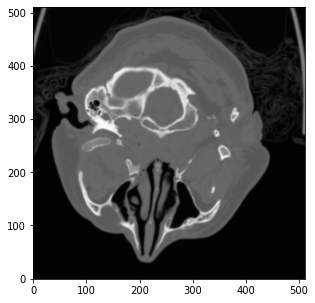

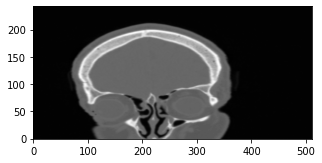

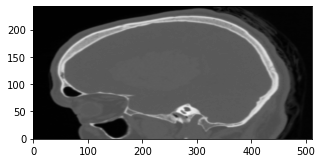

In [ ]:
# Display image slices
plt.figure(figsize=(5,5))
plt.imshow(img_array[30,:,:], cmap='gray', origin='lower')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_array[:,100,:], cmap='gray', origin='lower')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_array[:,:,160], cmap='gray', origin='lower')
plt.show()

If you tried coronal (xz) or sagittal (yz) slices, you will have noticed that the aspect ratio was wrong: the image seems 'squashed' in one dimension. This is because the resolution of this scan is *anisotropic*, i.e. the voxels do not have the same length in all directions.

`plt.imshow` has an option that lets you rescale the axes: `extent=(<left>, <right>, <bottom>, <top>)`.

**Task:** Using the `GetSize` and `GetSpacing` methods discussed earlier (note that SimpleITK's indexing convention is XYZ, whereas NumPy's is ZYX), try to set the display axes to the correct scale, in millimetres.

In [ ]:
# Obtain the pysical dimensions of the image, in millimetres
lengths = np.array(img.GetSize()) * np.array(img.GetSpacing())

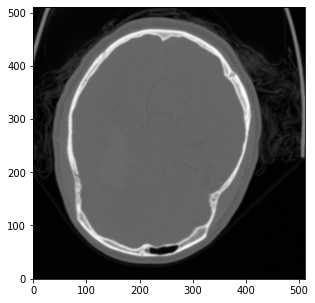

In [ ]:
# Display axial slice with the correct dimensions
# ADD YOUR CODE HERE
plt.figure(figsize=(5,5))
plt.imshow(img_array[100,:,:], cmap='gray', origin='lower')
plt.show()

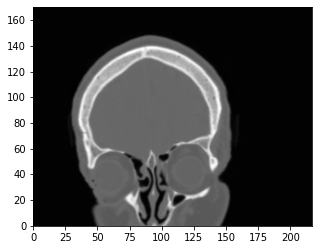

In [ ]:
# Display coronal slice with the correct dimensions
# ADD YOUR CODE HERE
plt.figure(figsize=(5,5))
plt.imshow(img_array[:,100,:], cmap='gray', origin='lower', extent = (0,lengths[0],0, lengths[2]))
plt.show()

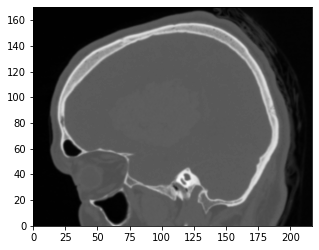

In [ ]:
# Display sagittal slice with the correct dimensions
# ADD YOUR CODE HERE
plt.figure(figsize=(5,5))
plt.imshow(img_array[:,:,160], cmap='gray', origin='lower', extent=(0,lengths[0],0,lengths[2]))
plt.show()

### Image statistics

Since the image data is numerical, it often makes sense to look at some of its statistics. Many basic statistics are readily available in NumPy, e.g. `np.min`, `np.max`, `np.mean`, `np.std` (standard deviation), `np.percentile` etc.

Let's have a look at the minimum, maximum and mean values of your image array.

In [ ]:
# Print minimum, maximum and mean of image array
print(np.min(img_array), np.max(img_array), np.mean(img_array))

-1024 1985 -446.63934140931434


To get a better idea of the distribution of intensities, it is helpful to analyse the image *histogram*. It is a simple bar plot expressing the frequencies of pixel intensity values found in the data array, in regularly-spaced intervals ('bins').

Let's use Matplotlib's `plt.hist` function to display the distribution of intensities in your image:
```
plt.hist(<array>.flatten(), bins=<no. bins>, density=True)
```

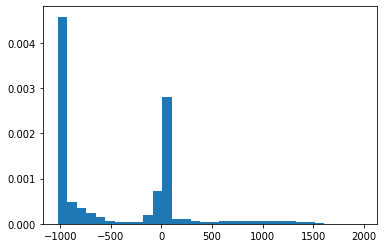

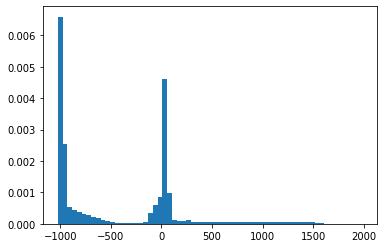

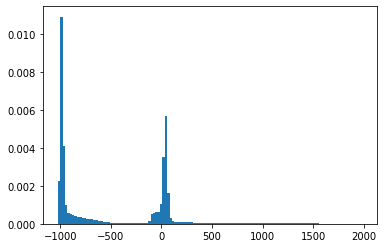

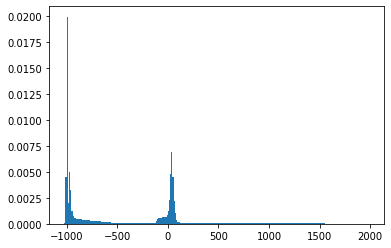

In [ ]:
# Plot the image histogram with values for the number of bins, e.g, 32, 64, 128, 256
plt.hist(img_array.flatten(), bins=32, density=True)
plt.show()
plt.hist(img_array.flatten(), bins=64, density=True)
plt.show()
plt.hist(img_array.flatten(), bins=128, density=True)
plt.show()
plt.hist(img_array.flatten(), bins=256, density=True)
plt.show()

You will notice two main peaks in the histogram with the left corresponding to values between -1000 and -500. This is the "background" area of the image corresponding to non-tissue or air. This area often takes a significant part of the image domain.

**Task:** Try plotting the histogram again by excluding pixels from the background region, and once more plotting only values close to the second peak (in the range [-500,500]). Hint: use logical operators on the NumPy array.

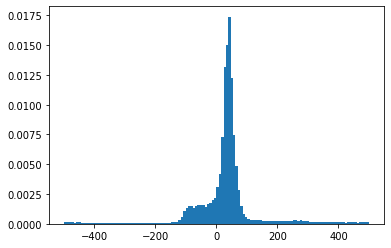

In [ ]:
# ADD YOUR CODE HERE
array = for_bins.flatten()
plt.hist(array[np.logical_and(array<500, array>-500)], bins=128, density=True)
plt.show()

### Window/Level

In general, medical images have pixel intensity ranges beyond the typical 256 grayscales (8-bit) that we know from conventional digital images. The loaded CT scan, for example, has a range of about [-1000,2000].

By default, `plt.imshow` will display the entire intensity range, mapping the minimum and maximum values in the array to the extremes of the colour scale. However, we can manually specify the display range, setting `clim=(<low>, <high>)` or independently `vmin=<low>` and/or `vmax=<high>`.

Using the concept of window/level, let's think about how to calculate parameters `clim=(<low>, <high>)` given a particular set of values for window and level. Also think about formulae for calculating the window and level that capture the full range of image intensities.

In [6]:
# Calculate parameters low and high from window and level
def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

print(wl_to_lh(160,70))
print(wl_to_lh(2000,300))
print(wl_to_lh(350,50))

(-10.0, 150.0)
(-700.0, 1300.0)
(-125.0, 225.0)


**Task:** Explore displaying the loaded brain CT scan `"ct-brain.nii.gz"` with different window/level settings. For example, using a window = 120 and level = 40 should give a good setting for displaying brain tissue. Other useful settings for CT images are a window = 2000 and level = 300 for good bone contrast, or window = 350 and level = 50 for abdominal organs.

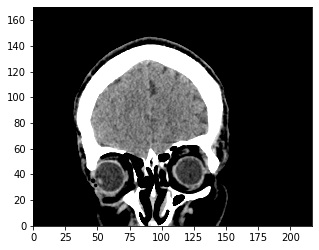

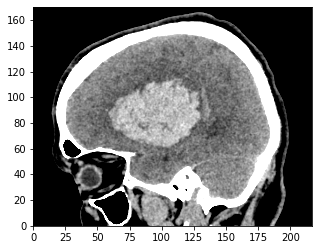

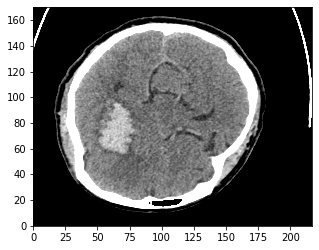

In [ ]:
# Display image slices with different window/level settings
# ADD YOUR CODE HERE
low, high = wl_to_lh(window=120, level=40)
plt.figure(figsize=(5,5))
plt.imshow(img_array[:,100,:], cmap='gray', origin='lower', 
           extent = (0,lengths[0],0, lengths[2]), clim=(low,high))
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_array[:,:,160], cmap='gray', origin='lower', 
           extent=(0,lengths[0],0,lengths[2]), clim=(low,high))
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(img_array[100,:,:], cmap='gray', origin='lower',
           extent=(0,lengths[0],0,lengths[2]), clim=(low,high))
plt.show()

**Task:** Try also some of the other images provided in the data folder, such as `"ct-abdomen.nii.gz"` for an abdominal CT scan showing organs such as the liver or kidneys, or `"mri-brain.nii.gz"` for an example of a brain MRI scan. Try to find a good window/level setting for the MRI scan that shows good contrast for gray and white matter tissue (Hint: z-slice 130 shows a good cross-section through the ventricles).

In [ ]:
# Display other images with different window/level settings
print(os.listdir(data_dir))
# ADD YOUR CODE HERE

['mri-brain-t1-contrast.nii.gz', 'ct-brain-lesion.nii.gz', 'ct-abdomen.nii.gz', 'mri-brain.nii.gz', 'mri-brain-t1.nii.gz', 'ct-brain.nii.gz', 'mri-brain-anisotropic.nii.gz', 'mri-brain-noisy.nii.gz', 'ct-brain-noisy.nii.gz']


In [7]:
# get image
img_abs = sitk.ReadImage(data_dir + 'ct-abdomen.nii.gz')
# print size
print('image size', print(img_abs.GetSize()))
print('image spacing',img_abs.GetSpacing())

# get array version
img_abs_array = sitk.GetArrayFromImage(img_abs)
print('array version size', img_abs_array.shape)


# Obtain the pysical dimensions of the image, in millimetres
lengths = np.array(img_abs.GetSize()) * np.array(img_abs.GetSpacing())
print('lengths in mm', lengths)

(512, 512, 125)
image size None
image spacing (0.703125, 0.703125, 3.75)
array version size (125, 512, 512)
lengths in mm [360.   360.   468.75]


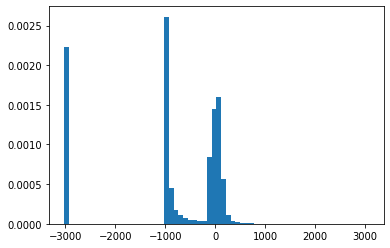

In [ ]:
plt.hist(img_abs_array.flatten(), bins=64, density=True)
plt.show()

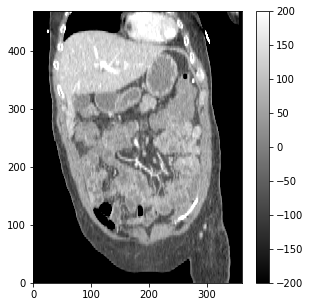

In [ ]:
low, high = wl_to_lh(window=400, level=0)

plt.figure(figsize=(5,5))
plt.imshow(img_abs_array[:,200,:], cmap='gray', origin='lower', 
           extent = (0,lengths[0],0, lengths[2]), clim=(low,high))
plt.colorbar()
plt.show()

### Multiplanar Image Viewer

Now ler's write a function to visualise an arbitrary medical volume, based on what you have done so far. It should take as input a SimpleITK image object (`img`), the slice indices (`x,y,z`) and window/level parameters (`window,level`), and display the specified axial (`z`), coronal (`y`) and sagittal (`x`) slices in grayscale and with correct axis dimensions and window/level contrast.

Note: If (`x,y,z`) are not specified (`=None`), the function should display the centre slices. If (`window,level`) are not specified, the function should calculate the window/level setting to cover the full intensity range.

In [8]:
def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()

The code below should give you an interactive way of displaying 3D medical images based on your `display_image` function.

In [68]:
from ipywidgets import interact, fixed
from IPython.display import display

def interactive_view(img):
    size = img.GetSize()
    img_array = sitk.GetArrayFromImage(img)
    interact(display_image,img=fixed(img),
             x=(0, size[0] - 1),
             y=(0, size[1] - 1),
             z=(0, size[2] - 1),
             window=(0,np.max(img_array) - np.min(img_array)),
             level=(np.min(img_array),np.max(img_array)))

interactive_view(img)

interactive(children=(IntSlider(value=95, description='x', max=191), IntSlider(value=127, description='y', max…

### Accessing voxel values

In Python, we can access a single element of a sequence with an integer index (`[index]`), or we can retrieve a contiguous sub-sequence with so-called *slice notation*: `[start:stop]`. Either or both arguments can be left blank: `[start:]` (`stop` defaults to the end), `[:stop]` (`start` defaults to `0`) or `[:]` (entire sequence).

A multi-dimensional array (such as our CT volume) can be indexed simultaneously in all dimensions, allowing us to access not only 2D slices, but also lines, rectangles, cuboids or individual voxels. A complete reference for NumPy array indexing can be found [here](https://docs.scipy.org/doc/numpy-1.11.0/reference/arrays.indexing.html).

Let's explore the indexing options for extracting 1D, 2D and 3D sub-arrays, and check the resulting shapes, e.g. `img_array[50, :, 100:120].shape`, comparing with the shape of the original array:

In [ ]:
print(img_array.shape)

(243, 512, 512)


In [ ]:
# Print the shape of indexed sub-arrays
print(img_array[50, :, 100:120].shape)

(512, 20)


Indexing is not just useful for reading data in an array, we can also set values in entire regions without having to explicitly write iterative loops.

**Task:** Select any 2D slice, try setting a rectangular region to an arbitrary value and visualise the result with `plt.imshow`:

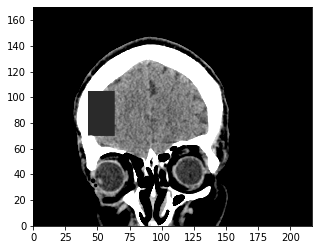

In [ ]:
# Extract a 2D slice
# Set a rectangular region to a constant (e.g. 0)
# Visualise the result with plt.imshow
# ADD YOUR CODE HERE

img_array_slice = img_array[:,100,:].copy()
img_array_slice[100:150,100:150] = 0
low, high = wl_to_lh(window=120, level=40)
plt.figure(figsize=(5,5))
plt.imshow(img_array_slice, cmap='gray', origin='lower', 
           extent = (0,lengths[0],0, lengths[2]), clim=(low,high))
plt.show()

### Image arithmetic

Beside simply computing statistics, we can also perform arithmetic operations with image intensities, such as multiplication by scalars, contrast adjustment or any pointwise function (e.g. [gamma correction](https://en.wikipedia.org/wiki/Gamma_correction) also known as Power-Law Transform.

**Task:** Load the image `"mri-brain-t1-contrast.nii.gz"` and visualise slices (`x=105, y=170, z=95`) with window/level (`window=800, level=400`) using your `display_image` function.

Let's implement a function for performing gamma correction, and apply it to the `"mri-brain-t1-contrast.nii.gz"` image (e.g., using (`c=10, gamma=3`)).

Note, for gamma correction you should first normalise the image intensity range to [0,1], apply gamma correction, and transform back to the original range. Some operations require the image data type to be floating point (`float`). NumPy arrays can be easily converted using `astype(<dtype>)`.

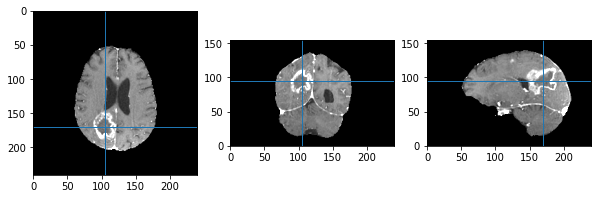

In [70]:
img1 = sitk.ReadImage(data_dir + 'mri-brain-t1-contrast.nii.gz')
display_image(img1, 105, 170, 95, 800, 400)

In [10]:
def gamma_correction(img, c, gamma):
    img_array = sitk.GetArrayFromImage(img).astype(float)
    min_value = np.min(img_array)
    max_value = np.max(img_array)    
    img_array = (img_array - min_value) / (max_value - min_value)
    img_array = c * np.power(img_array,gamma)
    img_array = img_array * (max_value - min_value) + min_value
    return sitk.GetImageFromArray(img_array)    

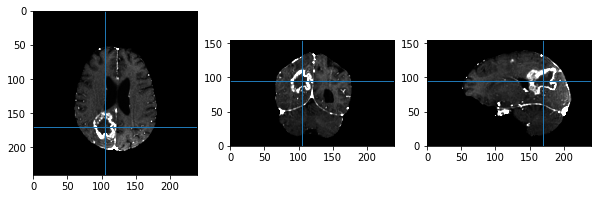

In [11]:
img1_corrected = gamma_correction(img1, 10, 3)
display_image(img1_corrected, 105, 170, 95, 800, 400)

For the image above, an intravenous contrast agent has been used to highlight blood and tumourous tissue. In this case, we also have a corresponding brain scan taken before the contrast agent has been administered.

Let's load the image `"mri-brain-t1.nii.gz"` and compare the two MRI scans with and without contrast using your `display_image` function. Hint: use the same window/level for both scans so you can better see the differences.

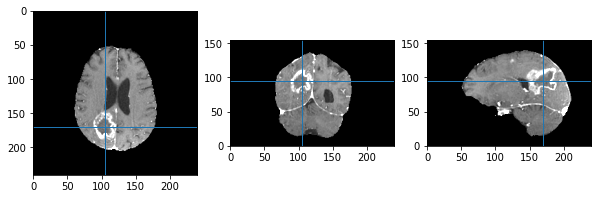

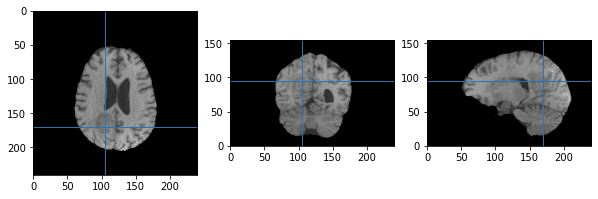

In [ ]:
img2 = sitk.ReadImage(data_dir + 'mri-brain-t1.nii.gz')

display_image(img1, 105, 170, 95, 800, 400)
display_image(img2, 105, 170, 95, 800, 400)

Note that these two images of the same patient are registered (i.e. spatially aligned).

**Task:** Now try displaying `(img1-img2)` (SimpleITK supports arithmetics with image objects) to see what was highlighted by the contrast agent. Hint: you might need to adjust the window/level for better visibility.

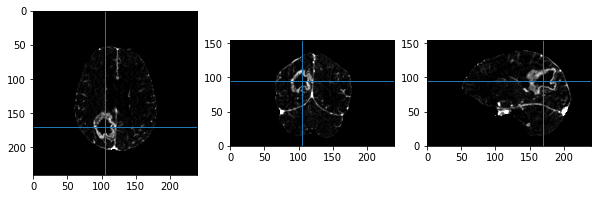

In [ ]:
# Display the difference image
# ADD YOUR CODE HERE
img_diff = img1 - img2
display_image(img_diff, 105, 170, 95, 800, 400)

**Task:** Try the same with gamma corrected version of the contrast image. Note, you might need to convert the data type of the non-contrast image to be able to subtract it from the gamma corrected image.

In [ ]:
#  Display the difference image of the gamma corrected images
# ADD YOUR CODE HERE

### Intensity normalisation

When performing statistical analysis or running machine learning methods on images, it is often useful to first *standardise* the intensities, i.e. make them have zero mean and unit variance. This is achieved by subtracting the mean and dividing by the standard deviation of the intensities. In mathematical terms, the standardised image $\tilde{I}$ is computed as
$$\tilde{I} = \frac{I - \mu}{\sigma}, \qquad\qquad \mu = \frac{1}{N} \sum_{n=1}^N I_n, \quad \sigma = \sqrt{\frac{1}{N} \sum_{n=1}^N (I_n - \mu)^2},$$
where $I$ is the original image, $N$ is its total number of voxels and $I_n$ is the intensity of voxel $n$.

**Task:** Try standardising the intensities of `img1`, using `np.mean` and `np.std`, and plot the resulting histogram:

In [22]:
img1_array.shape

(1172667,)

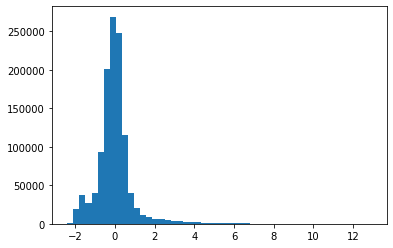

In [11]:
import numpy as np

img1_array = sitk.GetArrayFromImage(img1)  # Convert img1 to a NumPy array
img1_array = img1_array[img1_array > 0]    # Exclude the background voxels, with intensity 0

# img1_array is now an unstructured 'flat' array containing only the intensities of the brain voxels


# Compute its mean and standard deviation
img1_m = np.mean(img1_array)
img1_std = np.std(img1_array)
# Standardise the intensity array
img1_norm = (img1_array - img1_m) / img1_std
# Plot the histogram before and after normalisation
# ADD YOUR CODE HERE
plt.hist(img1_norm,bins=50)
plt.show()

### Image enhancement

We can also automatically enhance the contrast with [*histogram equalisation*](https://en.wikipedia.org/wiki/Histogram_equalization). It is a transformation applied to the image intensities which makes their distribution roughly uniform, i.e. all values occur approximately equally often in the image. Although it is not ideal for every application, the method is fast, simple to implement and useful for visualisation.

Below we define a function, `hist_eq`, which equalises the histogram of a given array, taking as input also the desired number of histogram bins (defaults to the maximum). The resulting array will have its values distributed almost uniformly between the original minimum and maximum values. The helper function `hist_eq_img` does exactly the same but can be called directly on SimpleITK images.

Let's try to understand the individual steps of the implementation of `hist_eq`.

In [12]:
def hist_eq(data, nbins=None):
    shape = data.shape
    data_min, data_max = data.min(), data.max()
    data = data.flatten()

    # nbins defaults to the integer range of values
    if nbins is None:
        nbins = int(data_max - data_min)

    # Compute image histogram
    counts, bins = np.histogram(data, bins=nbins)
    
    # Compute cumulative distribution function (CDF)
    cdf = counts.cumsum() / counts.sum()
    
    # Use linear interpolation of CDF to find new intensity values
    data_eq = np.interp(data, bins[:-1], (data_max - data_min) * cdf + data_min)
                    
    return data_eq.reshape(shape)

def hist_eq_img(img, nbins=None):
    data = sitk.GetArrayFromImage(img)
    data_eq = hist_eq(data, nbins)
    img_eq = sitk.GetImageFromArray(data_eq)
    img_eq.CopyInformation(img)
    return img_eq

**Task:** Now apply `hist_eq_img` to one of the SimpleITK images you have loaded and visualise it next to its original with your `display_image`:

In [28]:
img1_eq_arr = sitk.GetArrayFromImage(img1_eq)

(240, 240, 155)

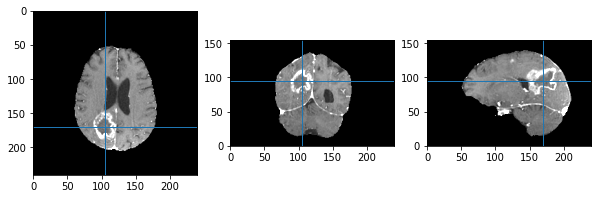

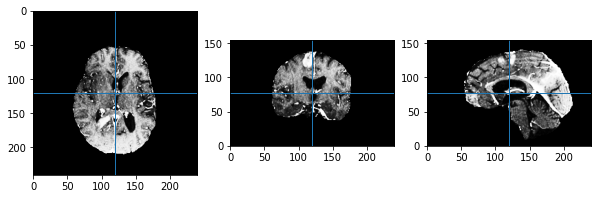

In [13]:
# Apply histogram equalisation to an image
img1_eq = hist_eq_img(img1)
# Display original image
display_image(img1, 105, 170, 95, 800, 400)
# Display equalised image
display_image(img1_eq)
# ADD YOUR CODE HERE

The following plots compare the intensity distributions before and after histogram equalisation.

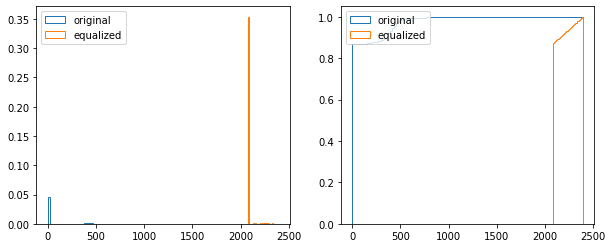

In [15]:
data_orig = sitk.GetArrayFromImage(img1).flatten()
data_eq = sitk.GetArrayFromImage(img1_eq).flatten()

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plt.hist(data_orig, bins=128, density=True, histtype='step', cumulative=False,label='original')
plt.hist(data_eq, bins=128, density=True, histtype='step', cumulative=False, label='equalized')
ax1.legend()
ax2 = plt.subplot(122)
plt.hist(data_orig, bins=128, density=True, histtype='step', cumulative=True, label='original')
plt.hist(data_eq, bins=128, density=True, histtype='step', cumulative=True, label='equalized')
ax2.legend()
plt.show()

### Filtering with SimpleITK

#### Smoothing

Occasionally we will acquire medical scans which include some amount of undesired noise.

One such noisy image might look like this:

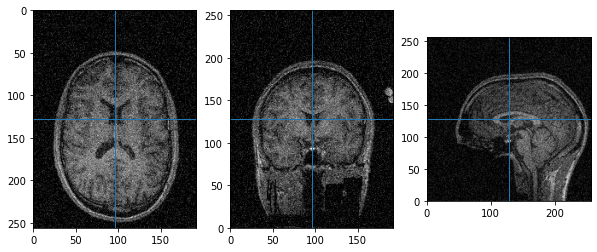

In [13]:
# We convert it to `float32` for compatibility with some functions we'll use later
img = sitk.Cast(sitk.ReadImage(data_dir + 'mri-brain-noisy.nii.gz'), sitk.sitkFloat32)
display_image(img)

A basic denoising technique is to *convolve* the image with a smoothing filter.

We can achieve this with SimpleITK using `sitk.DiscreteGaussian(<img>)` (it has a `variance` option, default `=1.0`).

**Task:** Try applying a Gaussian filter to the loaded image. Try out different values for the `variance` parameter:

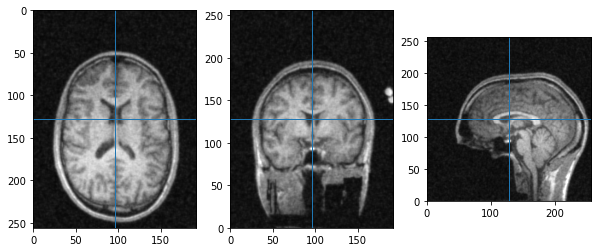

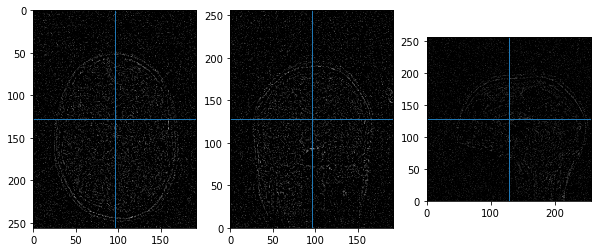

In [27]:
# ADD YOUR CODE HERE
img_gauss = sitk.DiscreteGaussian(img)
display_image(img_gauss, window=400, level=200)
display_image(img - img_gauss, window=400, level=200)

Comparing to the original noisy image, we can see that most of the visible noise is gone, but the image edges also lose their sharpness, in particular with larger values for the variance.

Interestingly, Gaussian smoothing can be interpreted as *isotropic diffusion*, i.e. image intensities are 'diffused' (think heat conduction) homogeneously in all directions for a length of 'time' proportional to the variance of the Gaussian filter. Extending on this idea, another popular approach for denoising is *anisotropic diffusion*, which adjusts the local 'conductivity' based on the image gradients. In other words, it attempts to smooth out flat regions while preserving the edges.

**Task:** Try out the SimpleITK function `sitk.GradientAnisotropicDiffusion(<img>)` (can take a few seconds). Play around with different values for the parameters of this filter:

In [17]:
help(sitk.GradientAnisotropicDiffusion)

Help on function GradientAnisotropicDiffusion in module SimpleITK.SimpleITK:

GradientAnisotropicDiffusion(image1, timeStep=0.125, conductanceParameter=3, conductanceScalingUpdateInterval=1, numberOfIterations=5)
    GradientAnisotropicDiffusion(Image image1, double timeStep=0.125, double conductanceParameter=3, unsigned int conductanceScalingUpdateInterval=1, uint32_t numberOfIterations=5) -> Image
    
    
    
    itk::simple::GradientAnisotropicDiffusionImageFilter Procedural Interface
    
    
    This function directly calls the execute method of GradientAnisotropicDiffusionImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::GradientAnisotropicDiffusionImageFilter for the object oriented interface



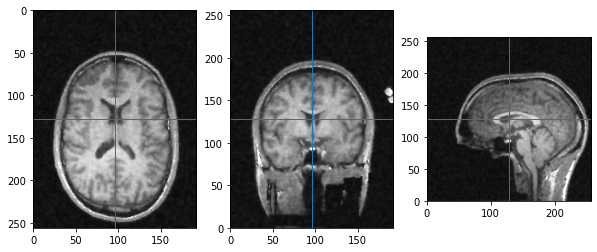

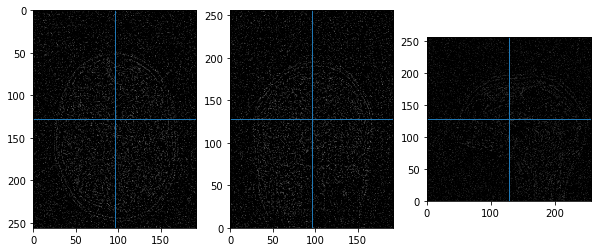

In [26]:
img_grad = sitk.GradientAnisotropicDiffusion(img)
display_image(img_grad, window=400, level=200)
display_image(img - img_grad, window=400, level=200)

#### Edge detection

Another common application of image filtering is estimating image gradients for edge detection.

Let us compute some spatial derivatives with `sitk.Derivative(<img>, direction=<dir>)`, where `<dir>` is 0, 1 or 2 for X, Y or Z, respectively.

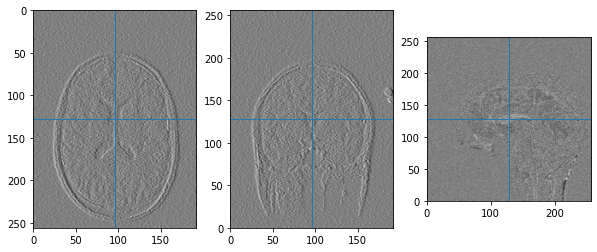

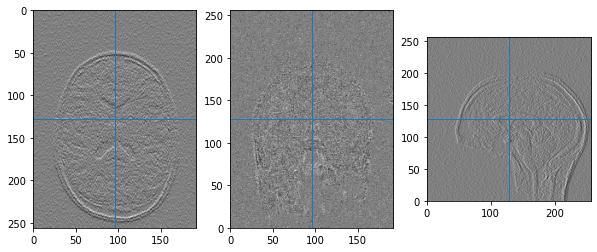

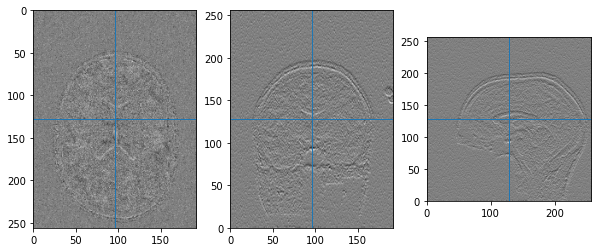

In [28]:
img_dx = sitk.Derivative(img, direction=0)
img_dy = sitk.Derivative(img, direction=1)
img_dz = sitk.Derivative(img, direction=2)
display_image(img_dx, level=0)
display_image(img_dy, level=0)
display_image(img_dz, level=0)

When we compute the magnitude of the gradients of an image, we obtain what is called an *edge map*, which is simply a local measure of the 'strength' of an edge.

This operation is readily available in SimpleITK with `sitk.SobelEdgeDetection(<img>)`:

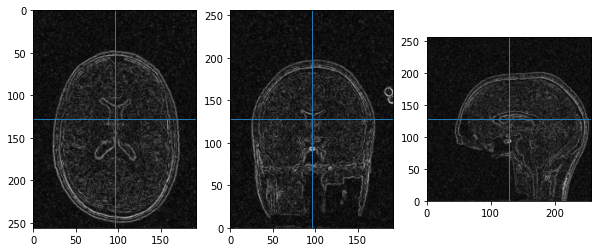

In [29]:
img_sobel = sitk.SobelEdgeDetection(img)
display_image(img_sobel)

Note how the derivatives look quite 'grainy', as we are differentiating the superimposed noise as well.

**Task**: How could you improve the edge detection on a noisy image?

In [ ]:
# ADD YOUR CODE HERE

#### Edge sharpening

Here we implement a `sharpen()` function which applies unsharp masking to an image. It uses `sitk.DiscreteGaussian`, as above, and takes the following arguments:
- `scale`: the standard deviation of the Gaussian filter
- `strength`: the scaling factor for the smoothed image

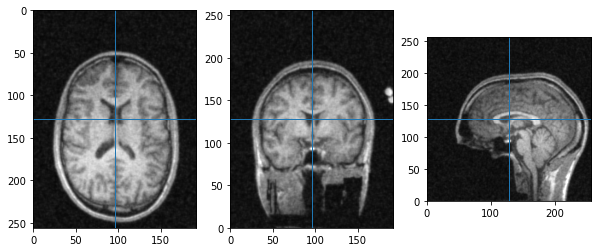

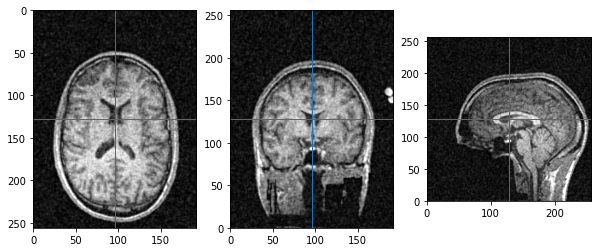

In [30]:
def sharpen(img, scale=1, strength=2):    
    # Apply unsharp masking
    img_smooth = sitk.DiscreteGaussian(img, scale)
    img_sharpened = img + (img - img_smooth) * strength
    return img_sharpened

img_sharp = sharpen(img_gauss, 1, 2)
display_image(img_gauss, window=400, level=200)
display_image(img_sharp, window=400, level=200)

### Resampling

Many image processing or computer vision algorithms adopt a multi-scale approach, for example making a coarse search over the entire image and then refining it at smaller scales. This can be achieved efficiently through the use of so-called *image pyramids*, which are formed by the base image and itself downsampled to lower resolutions, typically by a factor of 2 at each level.

**Task:** Implement a naïve downsampling function, by simply taking one every `<factor>` (integer-valued) pixels in each dimension.

*Hint:* SimpleITK image objects also support Python's indexing notation: `[start:stop:step]`, potentially omitting any of the arguments.

In [34]:
def downsample_naive(img, factor=2):
    sizes = img.GetSize()
    return img[0:sizes[0]:factor, 0:sizes[1]:factor, 0:sizes[2]:factor] # ADD YOUR CODE HERE

Now let us test with the MRI volume from before:

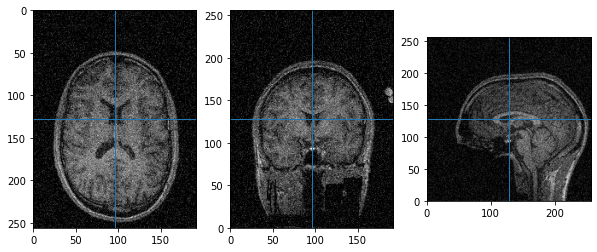

In [35]:
img = sitk.ReadImage(data_dir + "mri-brain-noisy.nii.gz")
display_image(img)

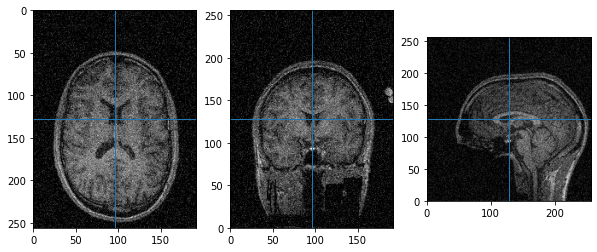

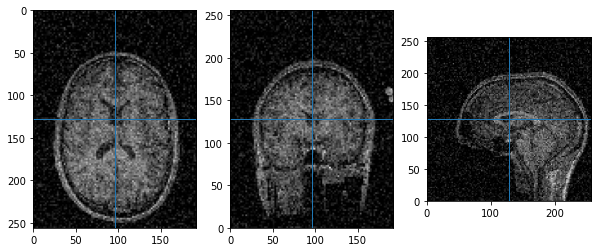

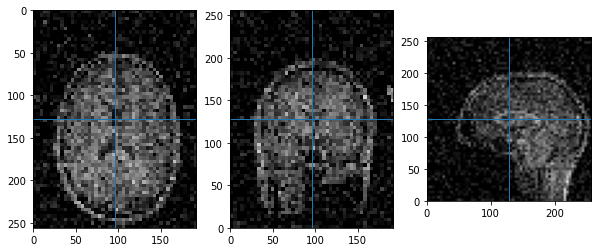

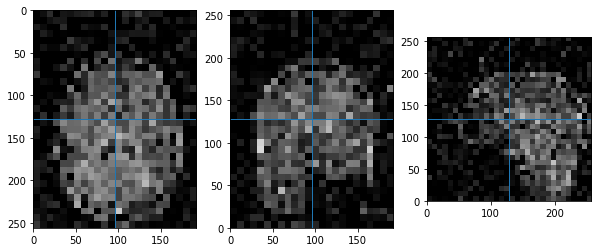

In [36]:
img_down_naive_1 = downsample_naive(img)
img_down_naive_2 = downsample_naive(img_down_naive_1)
img_down_naive_3 = downsample_naive(img_down_naive_2)

display_image(img)
display_image(img_down_naive_1)
display_image(img_down_naive_2)
display_image(img_down_naive_3)

It is known that naïve undersampling can produce *aliasing*, i.e. exacerbate high spatial frequencies (edges and noise) in the downsampled image, making it look jagged and 'blocky'. We usually circumvent this issue by first smoothing the image with a low-pass filter (e.g. Gaussian) before resampling the pixel values.

**Task:** Now try implementing a `downsample` method which first applies a Gaussian smoothing and then downsamples by an integer factor (no interpolation needed).

*Hint:* Recall the `variance` option for `sitk.DiscreteGaussian`. A Gaussian standard deviation of `0.5*factor` works well in practice, but feel free to experiment!

In [41]:
help(sitk.DiscreteGaussian)

Help on function DiscreteGaussian in module SimpleITK.SimpleITK:

DiscreteGaussian(*args)
    DiscreteGaussian(Image image1, double variance, unsigned int maximumKernelWidth=32, double maximumError=0.01, bool useImageSpacing=True) -> Image
    DiscreteGaussian(Image image1, VectorDouble variance, unsigned int maximumKernelWidth=32, VectorDouble maximumError, bool useImageSpacing=True) -> Image
    
    
    
    Blurs an image by separable convolution with discrete gaussian
    kernels. This filter performs Gaussian blurring by separable
    convolution of an image and a discrete Gaussian operator (kernel).
    
    
    This function directly calls the execute method of DiscreteGaussianImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::DiscreteGaussianImageFilter for the object oriented interface



In [39]:
def downsample(img, factor=2):
    sizes = img.GetSize()
    img = sitk.DiscreteGaussian(img)
    return img[0:sizes[0]:factor, 0:sizes[1]:factor, 0:sizes[2]:factor] 

Let's have a look at the results for this approach:

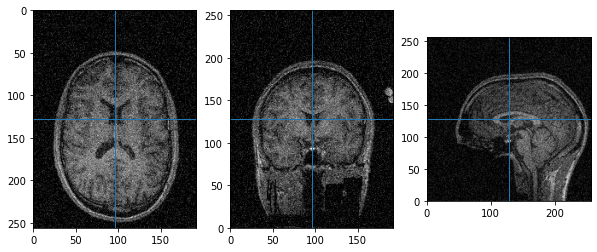

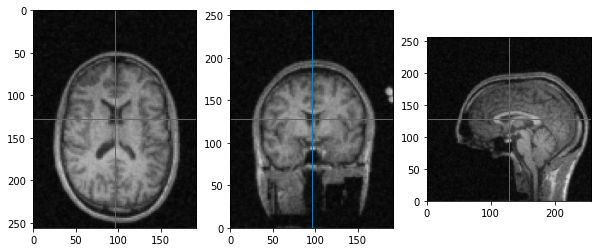

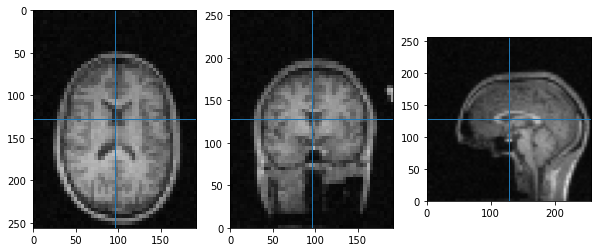

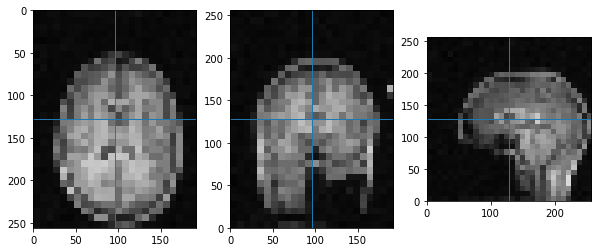

In [40]:
img_down_1 = downsample(img)
img_down_2 = downsample(img_down_1)
img_down_3 = downsample(img_down_2)

display_image(img)
display_image(img_down_1)
display_image(img_down_2)
display_image(img_down_3)

#### Resampling with SimpleITK

SimpleITK offers advanced resampling features that can be useful in many scenarios, e.g. when downsampling by non-integer factors or resampling to a specific resolution (e.g. isotropic).

Have a look at the `resample()` function we have implemented below and try to understand the role of each of the arguments to the `sitk.ResampleImageFilter`.

In [43]:
def resample(img, new_size=None, new_spacing=None):
    old_size = img.GetSize()
    old_spacing = img.GetSpacing()
    
    if new_size is None and new_spacing is None:
        return img
    
    if new_size is None:
        # Compute new image dimensions based on the desired rescaling of the voxel spacing
        new_size = [int(np.ceil(old_size[d] * old_spacing[d] / new_spacing[d])) for d in range(3)]

    if new_spacing is None:
        # Compute new voxel spacing based on the desired rescaling of the image dimensions
        new_spacing = [old_spacing[d] * old_size[d] / new_size[d] for d in range(3)]

    # Smooth the input image with anisotropic Gaussian filter
    img_smoothed = img
    for d in range(3):
        # Note how the blurring strength can be different in each direction,
        # if the scaling factors are different.
        factor = new_spacing[d] / old_spacing[d]
        sigma = 0.2 * factor
        img_smoothed = sitk.RecursiveGaussian(img_smoothed, sigma=sigma, direction=d)

    # Finally, apply the resampling operation
    img_resampled = sitk.ResampleImageFilter().Execute(
        img_smoothed,        # Input image
        new_size,            # Output image dimensions
        sitk.Transform(),    # Coordinate transformation. sitk.Transform() is a dummy identity transform,
                             # as we want the brain to be in exactly the same place. When we do image registration,
                             # for example, this can be a linear or nonlinear transformation.
        sitk.sitkLinear,     # Interpolation method (cf. also sitk.sitkNearestNeighbor and many others)
        img.GetOrigin(),     # Output image origin (same)
        new_spacing,         # Output voxel spacing
        img.GetDirection(),  # Output image orientation (same)
        0,                   # Fill value for points outside the input domain
        img.GetPixelID())    # Voxel data type (same)

    return img_resampled

Let's resample the MR image to an element spacing of 2x4x8mm.

Spacing: (1.0, 1.000000238418579, 0.9999995827674866)


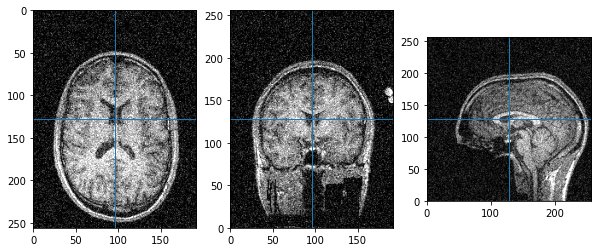

Spacing: (2.0, 4.0, 8.0)


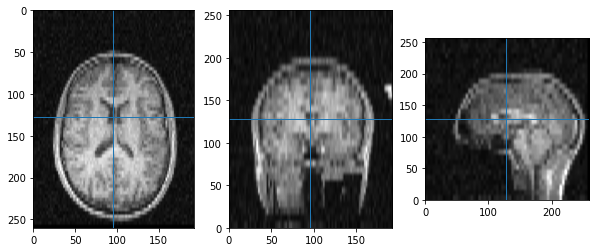

In [44]:
img_resampled = resample(img, new_spacing=[2, 4, 8])

print("Spacing: {}".format(img.GetSpacing()))
display_image(img, window=400, level=200)

print("Spacing: {}".format(img_resampled.GetSpacing()))
display_image(img_resampled, window=400, level=200)

Medical imaging data is often anisotropic. For many image analysis algorithms, however, it is easier to work with isotropic input data.

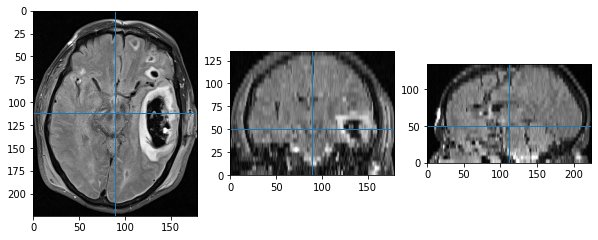

In [45]:
img3 = sitk.ReadImage(data_dir + 'mri-brain-anisotropic.nii.gz')
display_image(img3, z=10, window=800, level=400)

Let's try resampling the above image to an isotropic 1mm resolution, and display the result showing approximately the same xy-plane by setting an appropriate value for the `z` parameter in the `display_image` function.

Spacing: (0.699999988079071, 0.699999988079071, 5.0)


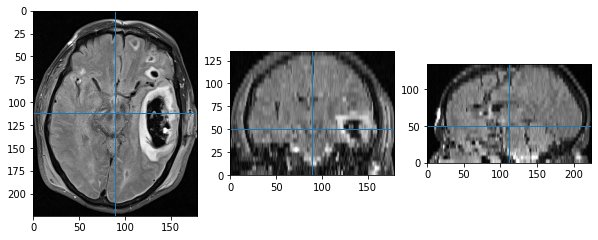

Spacing: (1.0, 1.0, 1.0)


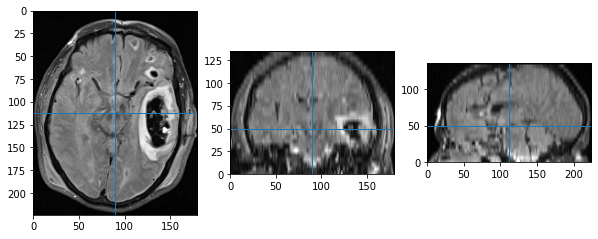

In [46]:
img3_resampled = resample(img3, new_spacing=[1, 1, 1])

print("Spacing: {}".format(img3.GetSpacing()))
display_image(img3, z=10, window=800, level=400)

print("Spacing: {}".format(img3_resampled.GetSpacing()))
display_image(img3_resampled, z=50, window=800, level=400)

### Segmentation

First let us define some helper functions to overlay an image with a segmentation, for good visualisation. `display_overlay()` takes as input the base image, a segmentation image (binary) and all the usual arguments for `display_image()`:

In [54]:
def label_overlay(img, seg):
    minmax = sitk.MinimumMaximumImageFilter()
    minmax.Execute(img)
    low, high = minmax.GetMinimum(), minmax.GetMaximum()
    img_norm = (img - low) / (high - low)
    img_uint8 = sitk.Cast(256 * img_norm, sitk.sitkUInt8)
    return sitk.LabelOverlay(img_uint8, seg)

def display_overlay(img, seg, *args, **kwargs):
    display_image(label_overlay(img, seg), *args, **kwargs)

#### Thresholding

The simplest form of segmentation is just based on a single cutoff in the intensities, with a manually specified threshold. Alternatively, we can specify an upper (U) and a lower (L) thresholds.

**Task:** Try to find a good UL thresholding to segment the lesion in the noisy CT scan.

*Hint 1:* SimpleITK images support comparison (`<`, `>`, `<=`, `>=`, `==`, `!=`) and logical ('and' `&`, 'or' `|`, 'xor' `^`, 'not' `~`) operators to produce binary images.

*Hint 2:* Image noise causes major problems for thresholding approaches. Try removing noise before thresholding the image and compare the results.

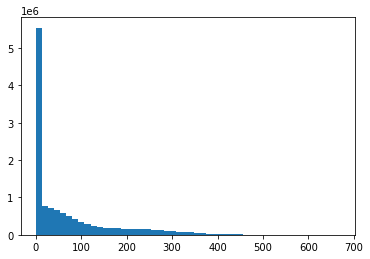

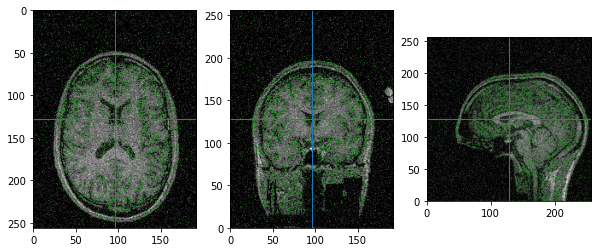

In [65]:
# ADD YOUR CODE HERE
plt.hist(sitk.GetArrayFromImage(img).flatten(), 50)
plt.show()

seg_1 = (img > 150. ) & (img < 200.)
display_overlay(img,seg_1)

Here we can observe one of the main shortcomings of purely intensity-based segmentation methods: we have no control over the location or spatial contiguity of the segmented regions. So even if we manage to segment most of the lesion, there are lot of areas included with the same intensity range outside the structure of interest.

#### Region growing

Region growing offers an alternative to simple thresholding that addresses the issue of spatial contiguity: it only labels the voxels which are *reachable* from a set of manually-specified *seed points*. In its simplest form, it is equivalent to thresholding, but limited to regions connected to the seeds.

Here we provide an implementation of region growing with UL thresholding.

- To initialise our zero-filled segmentation image, we use `sitk.Image(<img>.GetSize(), sitk.sitkUInt8)`. We call `<seg>.CopyInformation(<img>)` to copy the meta-data (spacing, origin, orientation) from the input image.
- We can use Python's `collections.deque` (double-ended queue). We use `.append(<elem>)` or `.extend(<list>)` to enqueue elements and `.popleft()` to dequeue an element (`.pop()` would work as a stack instead).
- Our algorithm should remember which voxels have already been visited. This can be achieved with a Python set (`set()`), with which we can do `.add(<elem>)` and `if <elem> in <set>:`.
- We use tuples to represent the voxel locations (e.g. `point=(x,y,z)`), then we can index directly into the SimpleITK image with them (e.g. `image[point]`).
- `neighbours(<point>, <img_size>)` returns the list of immediate neighbours of `<point>`, clipped at the image borders.

In [53]:
def neighbours(x, size):
    nbs = []
    for d in range(len(x)):
        if x[d] > 0:
            nb = list(x)
            nb[d] -= 1
            nbs.append(tuple(nb))
        if x[d] < size[d] - 1:
            nb = list(x)
            nb[d] += 1
            nbs.append(tuple(nb))
    return nbs

In [52]:
from collections import deque

def region_growing(img, seeds, low, high):
    size = img.GetSize()
    seg = sitk.Image(size, sitk.sitkUInt8)
    queue = deque()
    queue.extend(seeds)
    visited = set()
    while len(queue) > 0:
        x = queue.popleft()
        if x in visited:
            continue
        visited.add(x)
        if low <= img[x] < high:
            seg[x] = 1
            queue.extend(neighbours(x, size))
    seg.CopyInformation(img)
    return seg

**Task:** Try to find a good (x,y,z)-coordinate as a seed point for segmenting the lesion in the noisy CT scan with region growing. You may want to use the interactive image viewer `interactive_view(img)` to find coordinates inside the lesion. 

In [75]:
interactive_view(img_gauss)

interactive(children=(IntSlider(value=95, description='x', max=191), IntSlider(value=127, description='y', max…

Let's visually compare the results to a manual reference segmentation.

In [74]:
ref = sitk.ReadImage(data_dir + 'ct-brain-lesion.nii.gz')

print("Thresholding")
display_image(label_overlay(img_gauss, seg), *seed)
print("Region growing")
display_image(label_overlay(img_gauss, seg2), *seed)
print("Reference segmentation")
display_image(label_overlay(img_gauss, ref), *seed)

Thresholding


NameError: ignored

#### Segmentation Evaluation

Let's now quantitatively evaluate the segmentations using different performance measures. SimpleITK has many important measures already implemented.

First, we extract the surfaces from the segmentations.

In [50]:
seg_contour = sitk.LabelContour(seg)
seg2_contour = sitk.LabelContour(seg2)
ref_contour = sitk.LabelContour(ref)

print("Thresholding - Surface")
display_image(label_overlay(img_gauss, seg_contour), *seed)
print("Region growing - Surface")
display_image(label_overlay(img_gauss, seg2_contour), *seed)
print("Reference segmentation - Surface")
display_image(label_overlay(img_gauss, ref_contour), *seed)

NameError: ignored

Then we can use SimpleITK to compute overlap measures such as Jaccard Index (JI) and Dice Similarity Coefficient (DSC). We can also directly compute the Hausdorff Distance (HD) and Symmetric Average Surface Distance (ASD) from the segmentation contours using SimpleITK's `HausdorffDistanceImageFilter`. (Note, ASD is called AverageHausdorffDistance in SimpleITK)

In [ ]:
overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()
hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

overlap_measures_filter.Execute(ref, seg)
hausdorff_distance_filter.Execute(ref_contour, seg_contour)
print('\nThresholding')
print('JI\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC\t' + str(overlap_measures_filter.GetDiceCoefficient()))
print('HD\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))
print('ASD\t' + str(hausdorff_distance_filter.GetAverageHausdorffDistance()))

overlap_measures_filter.Execute(ref, seg2)
hausdorff_distance_filter.Execute(ref_contour, seg2_contour)
print('\nRegion growing')
print('JI\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC\t' + str(overlap_measures_filter.GetDiceCoefficient()))
print('HD\t' + str(hausdorff_distance_filter.GetHausdorffDistance()))
print('ASD\t' + str(hausdorff_distance_filter.GetAverageHausdorffDistance()))

We could also compute the ASD ourselves using Euclidean distance maps following the approach described from slide 37 onwards. This is a bit more involved. We can make use of the `SignedMaurerDistanceMap` in SimpleITK.

In [ ]:
seg_distance_map = sitk.SignedMaurerDistanceMap(seg_contour, squaredDistance=False, useImageSpacing=True)
seg2_distance_map = sitk.SignedMaurerDistanceMap(seg2_contour, squaredDistance=False, useImageSpacing=True)
ref_distance_map = sitk.SignedMaurerDistanceMap(ref_contour, squaredDistance=False, useImageSpacing=True)

print('Thresholding - Distance Map')
display_image(seg_distance_map, *seed, window=100, level=20)

print('Region growing - Distance Map')
display_image(seg2_distance_map, *seed, window=100, level=20)

print('Reference - Distance Map')
display_image(ref_distance_map, *seed, window=100, level=20)

We convert everything to numpy arrays.

In [ ]:
# segmentations
seg_np = sitk.GetArrayFromImage(seg).astype(bool)
seg2_np = sitk.GetArrayFromImage(seg2).astype(bool)
ref_np = sitk.GetArrayFromImage(ref).astype(bool)

# surfaces
seg_contour_np = sitk.GetArrayFromImage(seg_contour).astype(bool)
seg2_contour_np = sitk.GetArrayFromImage(seg2_contour).astype(bool)
ref_contour_np = sitk.GetArrayFromImage(ref_contour).astype(bool)

# distance maps
seg_distance_map_np = sitk.GetArrayFromImage(seg_distance_map)
seg2_distance_map_np = sitk.GetArrayFromImage(seg2_distance_map)
ref_distance_map_np = sitk.GetArrayFromImage(ref_distance_map)

Now we can compute ASD by reading out the distances for surface pixels overlaid on the respective distance map.

In [ ]:
distance_dir1 = np.mean(ref_distance_map_np[seg_contour_np])
distance_dir2 = np.mean(seg_distance_map_np[ref_contour_np])
print('\nThresholding')
print('ASD (ours)\t' + str(np.mean([distance_dir1, distance_dir2])))

hausdorff_distance_filter.Execute(ref_contour, seg_contour)
print('ASD (SimpleITK)\t' + str(hausdorff_distance_filter.GetAverageHausdorffDistance()))

distance_dir1 = np.mean(ref_distance_map_np[seg2_contour_np])
distance_dir2 = np.mean(seg2_distance_map_np[ref_contour_np])
print('\nRegion growing')
print('ASD (ours)\t' + str(np.mean([distance_dir1, distance_dir2])))

hausdorff_distance_filter.Execute(ref_contour, seg2_contour)
print('ASD (SimpleITK)\t' + str(hausdorff_distance_filter.GetAverageHausdorffDistance()))

**Task:** Similarily, we can compute the Hausdorff Distance ourselves. Try it and compare the values to the ones obtained with SimpleITK.

In [ ]:
# ADD YOUR CODE HERE

It's also quite easy to compute the Jaccard Index (JI) and Dice Similarity Coefficient (DSC) directly using numpy. To this end, let's first determine the true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

In [ ]:
tp = np.sum( seg_np &  ref_np)
fp = np.sum( seg_np & ~ref_np)
tn = np.sum(~seg_np & ~ref_np)
fn = np.sum(~seg_np &  ref_np)

**Task:** Now compute JI and DSC for both results, thresholding and region growing, and compare the values to the ones obtained with SimpleITK.

In [ ]:
# ADD YOUR CODE HERE
jaccard = 0
jaccard2 = 0
dice = 0
dice2 = 0

In [ ]:
overlap_measures_filter.Execute(ref, seg)
print('\nThresholding')
print('JI (ours)\t' + str(jaccard))
print('JI (SimpleITK)\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC (ours)\t' + str(dice))
print('DSC (SimpleITK)\t' + str(overlap_measures_filter.GetDiceCoefficient()))

overlap_measures_filter.Execute(ref, seg2)
print('\nRegion growing')
print('JI (ours)\t' + str(jaccard2))
print('JI (SimpleITK)\t' + str(overlap_measures_filter.GetJaccardCoefficient()))
print('DSC (ours)\t' + str(dice2))
print('DSC (SimpleITK)\t' + str(overlap_measures_filter.GetDiceCoefficient()))